In [ ]:
using Flight.FlightCore
using Flight.FlightLib
using Flight.FlightExamples
using Flight.FlightExamples.C172X.C172XControl
using Flight.FlightLib.Linearization: subsystem, delete_vars
using Flight.FlightLib.Control.Discrete: PIDData, LQRDataPoint
using Flight.FlightLib.Control.PIDOpt: Settings, Metrics, optimize_PID, build_PID, check_results

using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra
using Plots

includet("c172x_design.jl"); using .C172XControlDesign


SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


In [2]:
global_search = false

aircraft = Cessna172Xv0(NED()) |> Model #linearization requires NED kinematics

h = 2050
EAS = 40
flaps = C172XControl.flaps_schedule(EAS)
payload = C172.PayloadY()
# design_point = C172.TrimParameters(; Ob = Geographic(LatLon(), HEllip(h)), EAS, flaps, payload)
design_point = C172.TrimParameters()
@show Float64(design_point.flaps)

#complete lateral model
lss_lat = get_design_model!(aircraft, design_point; model = :lat);
P_lat = named_ss(lss_lat);

lss_lat.A[:ψ, :] |> display
lss_lat.A[:, :ψ] |> display
lss_lat.C[:, :ψ] |> display

Float64(design_point.flaps) = 0.0


ComponentVector{Float64}(p = 0.0, r = 1.0002770255055644, ψ = 1.3081583542942613e-9, φ = -8.294400071094033e-6, EAS = 8.168404297665984e-14, β = -1.9413536572282852e-7, β_filt = 0.0, ail_p = 0.0, rud_p = 0.0)

ComponentVector{Float64}(p = -5.192771197273793e-7, r = -2.3910991886208835e-6, ψ = 1.3081583542942613e-9, φ = 5.55473278000434e-8, EAS = -2.914903176264774e-7, β = -1.354748095995078e-7, β_filt = 0.0, ail_p = 0.0, rud_p = 0.0)

ComponentVector{Float64}(p = 0.0, r = 0.0, ψ = 1.0, φ = 0.0, EAS = 0.0, β = 0.0, β_filt = 0.0, ail_p = 0.0, rud_p = 0.0, f_y = -1.2223608791828156e-8, χ = 1.0, aileron_cmd = 0.0, rudder_cmd = 0.0)

As one would expect, heading is roughly a pure integral of yaw rate. This will be a problem when
designing a LQR tracker for which the choice of command variables involves non-zero steady state yaw
rate. Since we cannot maintain constant heading with an arbitrary yaw rate, true static equilibrium
will not exist and the block $H_x F^{-1} G$ in the feedforward gain matrix required for tracking
such command variables will be singular.

This would not be an issue if we picked for instance $\chi$ and $\beta$ as command variables,
because the true equilibrium we need does exist for an arbitrary combination of the two. However,
this is not an appealing choice, because we would like to be able to control the roll axis
explicitly, rather than implicitly through $\chi$.

Since the coupling of $\psi$ into the remaining states is extremely weak, we can simply drop $\psi$
from the state, design the LQR trackers on the reduced plant, and then connect them back to the full
plant. 

In [3]:
#we should also remove χ because of its coupling to ψ
lss_red = delete_vars(lss_lat, (:ψ, :χ))
P_red = named_ss(lss_red);

In [4]:
dampreport(P_lat)
dampreport(P_red)
controllability(P_lat) |> display
controllability(P_red) |> display

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -5.96e-06          |  1            |  5.96e-06     |  9.49e-07     |  1.68e+05     |
| -0.0227            |  1            |  0.0227       |  0.00361      |  44.1         |
| -0.0808            |  1            |  0.0808       |  0.0129       |  12.4         |
| -0.686  ±   2.69im |  0.247        |  2.77         |  0.442        |  1.46         |
| -10.5              |  1            |  10.5         |  1.66         |  0.0956       |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Fr

(iscontrollable = true, ranks = [9, 9, 9, 9, 9, 9, 9, 9, 9], sigma_min = [0.0857449368582107, 8.087684865485475, 8.087684865485475, 4.29215502947079, 0.39337736171692594, 0.39337736171692594, 0.1411366485008093, 0.1305310430652904, 0.12957841861792294])

(iscontrollable = true, ranks = [8, 8, 8, 8, 8, 8, 8, 8], sigma_min = [0.08574493721515979, 8.087922529138387, 8.087922529138387, 4.293983770264831, 0.393426940287987, 0.393426940287987, 0.4887471270462975, 0.48457557995755274])

We see that removing $\psi$ as a state eliminates an extremely slow stable pole (maybe
geodesy-related?). The remaining poles are virtually unaffected. Also, it significantly improves the
condition of the dynamics matrix:

In [5]:
cond(P_lat.A) |> display
cond(P_red.A) |> display

1.0288135228467365e8

6426.667290019191

# 1. LQR SAS

For pure stability augmentation, we must not try to impose aileron and rudder as command variables,
because it is not feasible to achieve a steady state for arbitrary aileron and rudder positions.
Therefore, we simply compute a suitable feedback matrix to tame the lateral modes, and leave the
feedforward matrix as a unit passthrough.

In [ ]:
P_ar, data_ar2ar = let lss = lss_red

    x_trim = lss.x0
    n_x = length(x_trim)
    x_labels = collect(keys(x_trim))
    @assert tuple(x_labels...) === propertynames(C172XControl.XLatRed())

    u_trim = lss.u0
    n_u = length(u_trim)
    u_labels = collect(keys(u_trim))
    @assert tuple(u_labels...) === propertynames(C172XControl.ULatRed())

    z_labels = [:aileron_cmd, :rudder_cmd]
    z_trim = lss.y0[z_labels]
    n_z = length(z_labels)
    @assert tuple(z_labels...) === propertynames(C172XControl.Zar())

    #weight matrices
    Q = C172XControl.XLatRed(p = 0, r = 0.1, φ = 0.1, EAS = 0.0, β = 0, β_filt = 0, ail_p = 0, rud_p = 0) |> diagm
    R = C172XControl.ULatRed(aileron_cmd = 0.1, rudder_cmd = 0.01) |> diagm

    #feedback gain matrix
    P = named_ss(lss)
    K_fbk = lqr(P, Q, R)

    #passthrough feedforward
    K_fwd = Matrix{Float64}(I, n_z, n_z)

    #no integral control
    K_int = zeros(n_u, n_z)

    u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
    u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
    u_labels_sum = Symbol.(string.(u_labels) .* "_sum")
    z_labels_ref = Symbol.(string.(z_labels) .* "_ref")

    K_fbk_ss = named_ss(ss(K_fbk); u = x_labels, y = u_labels_fbk)
    K_fwd_ss = named_ss(ss(K_fwd), u = z_labels_ref, y = u_labels_fwd)

    #summing junctions
    aileron_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd- aileron_cmd_fbk")
    rudder_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk")

    connections_fbk = vcat(
        Pair.(x_labels, x_labels),
        Pair.(u_labels_fbk, u_labels_fbk),
        Pair.(u_labels_fwd, u_labels_fwd),
        Pair.(u_labels_sum, u_labels),
        )

    P_ar = connect([P_lat, aileron_sum, rudder_sum, K_fbk_ss, K_fwd_ss],
                    connections_fbk; w1 = z_labels_ref, z1 = P_lat.y)

    display(K_fbk)

    data_ar2ar = LQRDataPoint(;
        K_fbk = Matrix(K_fbk), K_fwd = Matrix(K_fwd), K_int = Matrix(K_int),
        x_trim = Vector(x_trim), u_trim = Vector(u_trim), z_trim = Vector(z_trim))


    (P_ar, data_ar2ar)

end

2×8 Matrix{Float64}:
 0.0874957  0.089795  0.917926  0.000765091  …  0.0  0.0627199   0.000171872
 0.0470451  2.44536   0.79359   0.00163623      0.0  0.00171872  0.159993

(NamedStateSpace{Continuous, Float64}
A = 
 -10.193941724934115       2.512310663091281     -5.192771197273793e-7    -2.278062885253604e-5    0.014869342017285089   -22.986218645306096        0.0   16.061719616737804       -1.4373800340373328
  -0.22562054055702074    -1.1969041003060659    -2.3910991886208835e-6    9.795807379266684e-6    1.883317598169155e-5     6.84012623755014         0.0   -0.3851926684287586       1.445579158619316
   0.0                     1.0002770255055644     1.3081583542942613e-9   -8.294400071094033e-6    8.168404297665984e-14   -1.9413536572282852e-7    0.0    0.0                      0.0
   1.0                     0.023556862404204588   5.55473278000434e-8     -1.3081583670827264e-9   3.468484302233377e-12   -8.243421411239934e-6     0.0    0.0                      0.0
  -0.004923780310014968    0.04529773653973528   -2.914903176264774e-7    -0.0001982979931474408  -0.08336483530793869     -4.739778855323346        0.0    4.973418193602401e-18    0.0
  -

In [7]:
dampreport(P_red)
dampreport(P_ar)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0227            |  1            |  0.0227       |  0.00361      |  44.1         |
| -0.0808            |  1            |  0.0808       |  0.0129       |  12.4         |
| -0.686  ±   2.69im |  0.247        |  2.77         |  0.442        |  1.46         |
| -10.5              |  1            |  10.5         |  1.66         |  0.0956       |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (r

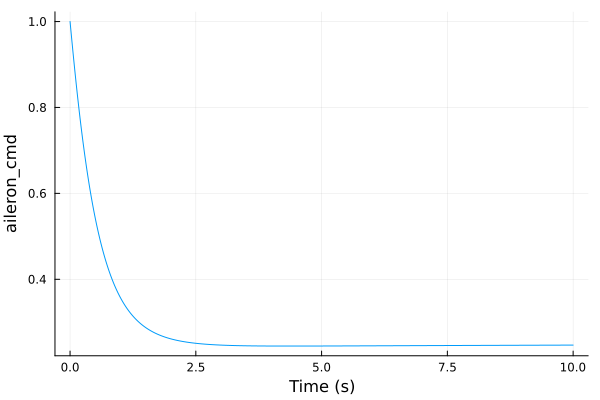

In [8]:
#aileron command reference to aileron actuator command step response (the SAS
#inhibits sustained aileron deflection)
step(P_ar[:aileron_cmd, :aileron_cmd_ref], 10) |> plot

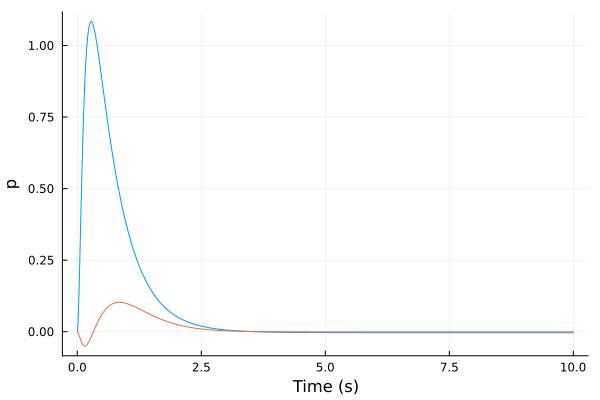

In [9]:
#aileron command reference to roll rate step response
step(P_ar[:p, :aileron_cmd_ref], 10) |> plot
#rudder command reference to roll rate step response
step(P_ar[:p, :rudder_cmd_ref], 10) |> plot!

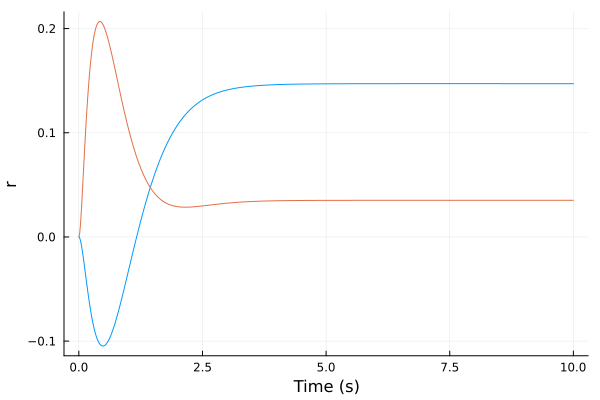

In [10]:
#aileron command reference to yaw rate step response
step(P_ar[:r, :aileron_cmd_ref], 10) |> plot
#rudder command reference to yaw rate step response
step(P_ar[:r, :rudder_cmd_ref], 10) |> plot!
#both inputs bank the aircraft into a turn, so a sustained yaw rate follows

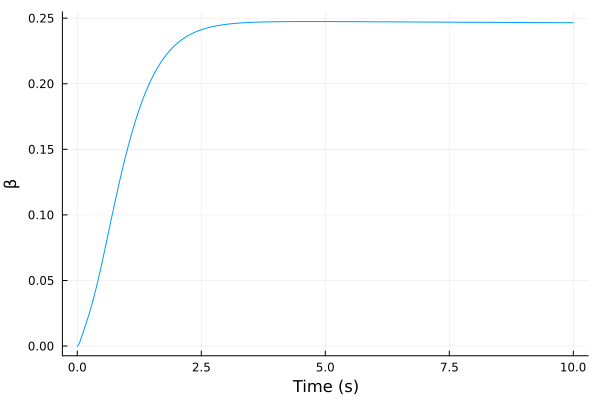

In [11]:
#no automatic turn coordination!
step(P_ar[:β, :aileron_cmd_ref], 10) |> plot

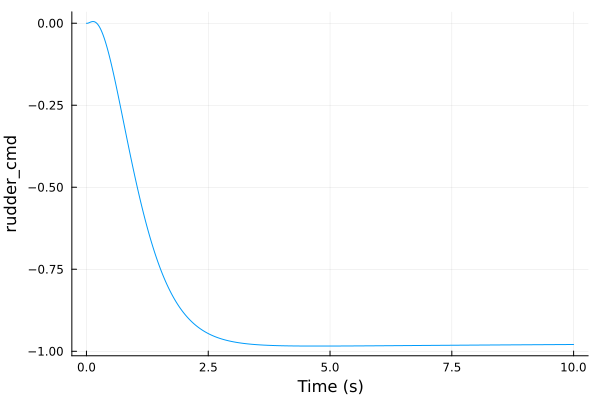

In [12]:
step(P_ar[:rudder_cmd, :aileron_cmd_ref], 10) |> plot

# 2. LQR CAS

We now address the design of a MIMO lateral-directional CAS. The first question is which two
variables we should select as command variables.

Since bank angle is essentially a pure integral of roll rate, asymptotic equilibrium is only
possible for a zero steady-state roll rate. This means that selecting roll rate as
a command variable is not physically reasonable, and would likely yield a (nearly) singular feedforward matrix.

How about aileron command? Looking at the stability-augmented system's response, we see that a step
input in aileron command reference produces an initial aileron command output of 1, but then equilibrium is
achieved with a much smaller (although not zero) value. This means that achieving unit
steady-state output in the regulated system would require very large feedforward gains and would
yield an extremely high initial actuator command, well beyond 1 (at which actuator is already
saturated). That suggests aileron command isn't a good choice for a tracked variable either.

Looking at the stability-augmented system's aileron set point to bank angle response, we see that it
starts at zero and then stabilizes at a value close to 1. This suggests that $\phi$ 
would make for a good command variable. Once we have a CAS design with
$\phi$ as an input, we can add an external SISO loop to command roll rate, with the
necessary compensation to achieve zero steady state error.

Another variable we are interested in controlling explicitly is $\beta$ (or alternatively lateral
specific force, $f_y$). In most cases we want to maintain $\beta = 0$ for turn coordination, but we
might want to command non-zero values for scenarios such as cross-wind landing. If we select $\beta$ as the only
command variable, we will get a 2x1 feedforward matrix which will provide a combination of aileron
and rudder that achieves the desired steady-state $\beta$ (specifically, the optimal one in the
least-squares sense). However, we obviously also want to retain roll control. But if we add an
arbitrary external aileron command to that prescribed by the $\beta$ feedforward, we will no longer
achieve the desired steady-state $\beta$ value.


In [ ]:
P_φβ, data_φβ2ar = let lss = lss_red

    x_trim = lss.x0
    n_x = length(x_trim)
    x_labels = collect(keys(x_trim))
    @assert tuple(x_labels...) === propertynames(C172XControl.XLatRed())

    u_trim = lss.u0
    n_u = length(u_trim)
    u_labels = collect(keys(u_trim))
    @assert tuple(u_labels...) === propertynames(C172XControl.ULatRed())

    z_labels = [:φ, :β]
    z_trim = lss.y0[z_labels]
    n_z = length(z_labels)
    @assert tuple(z_labels...) === propertynames(C172XControl.Zφβ())

    ################################ feedback ###################################

    #weight matrices
    Q = C172XControl.XLatRed(p = 0, r = 0.1, φ = 2, EAS = 0, β = 5, β_filt = 0, ail_p = 0, rud_p = 0) |> diagm
    R = C172XControl.ULatRed(aileron_cmd = 0.1, rudder_cmd = 0.03) |> diagm

    #feedback gain matrix
    P = named_ss(lss)
    K_fbk = lqr(P, Q, R)

    ################################ feedforward ###########################

    A = lss.A
    B = lss.B
    C = lss.C[z_labels, :]
    D = lss.D[z_labels, :]

    #useful signal labels for connections
    u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk") #outputs from feedback block
    u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd") #outputs from feedforward block
    u_labels_sum = Symbol.(string.(u_labels) .* "_sum") #outputs from summing junctions
    u_labels_ref = Symbol.(string.(u_labels) .* "_ref") #references, inputs to P
    z_labels_ref = Symbol.(string.(z_labels) .* "_ref")

    L = [A B; C D]
    M = inv(L)
    M_12 = M[1:n_x, n_x+1:end]
    M_22 = M[n_x+1:end, n_x+1:end]
    K_fwd = M_22 + K_fbk * M_12
    K_fwd_ss = named_ss(ss(K_fwd), u = z_labels_ref, y = u_labels_fwd)

    #no integral control
    K_int = zeros(n_u, n_z)

    K_fbk_ss = named_ss(ss(K_fbk); u = x_labels, y = u_labels_fbk)
    K_fwd_ss = named_ss(ss(K_fwd), u = z_labels_ref, y = u_labels_fwd)

    #summing junctions
    aileron_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd- aileron_cmd_fbk")
    rudder_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk")

    display(K_fwd)

    connections_fbk = vcat(
        Pair.(x_labels, x_labels),
        Pair.(u_labels_fbk, u_labels_fbk),
        Pair.(u_labels_fwd, u_labels_fwd),
        Pair.(u_labels_sum, u_labels),
        )

    P_φβ = connect([P_lat, aileron_sum, rudder_sum, K_fbk_ss, K_fwd_ss],
                    connections_fbk; external_inputs = z_labels_ref, external_outputs = P_lat.y);

    data_φβar = LQRDataPoint(;
        K_fbk = Matrix(K_fbk), K_fwd = Matrix(K_fwd), K_int = Matrix(K_int),
        x_trim = Vector(x_trim), u_trim = Vector(u_trim), z_trim = Vector(z_trim))

    (P_φβ, data_φβar)

end

2×2 Matrix{Float64}:
 4.42213    1.12657
 1.27222  -13.6661

(NamedStateSpace{Continuous, Float64}
A = 
 -10.193941724934115       2.512310663091281     -5.192771197273793e-7    -2.278062885253604e-5    0.014869342017285089   -22.986218645306096        0.0   16.061719616737804       -1.4373800340373328
  -0.22562054055702074    -1.1969041003060659    -2.3910991886208835e-6    9.795807379266684e-6    1.883317598169155e-5     6.84012623755014         0.0   -0.3851926684287586       1.445579158619316
   0.0                     1.0002770255055644     1.3081583542942613e-9   -8.294400071094033e-6    8.168404297665984e-14   -1.9413536572282852e-7    0.0    0.0                      0.0
   1.0                     0.023556862404204588   5.55473278000434e-8     -1.3081583670827264e-9   3.468484302233377e-12   -8.243421411239934e-6     0.0    0.0                      0.0
  -0.004923780310014968    0.04529773653973528   -2.914903176264774e-7    -0.0001982979931474408  -0.08336483530793869     -4.739778855323346        0.0    4.973418193602401e-18    0.0
  -

In [14]:
dampreport(P_φβ)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -1.87e-07          |  1            |  1.87e-07     |  2.97e-08     |  5.36e+06     |
| -0.0834            |  1            |  0.0834       |  0.0133       |  12           |
| -3.09   ±   3.37im |  0.676        |  4.57         |  0.727        |  0.324        |
| -7.52   ±   3.25im |  0.918        |  8.19         |  1.3          |  0.133        |
| -19.9              |  1            |  19.9         |  3.16         |  0.0504       |
| -20.3              |  1            |  20.3         |  3.24         |  0.0492       |
| -50                |  1            |  50           |  7.96         |  0.02         |


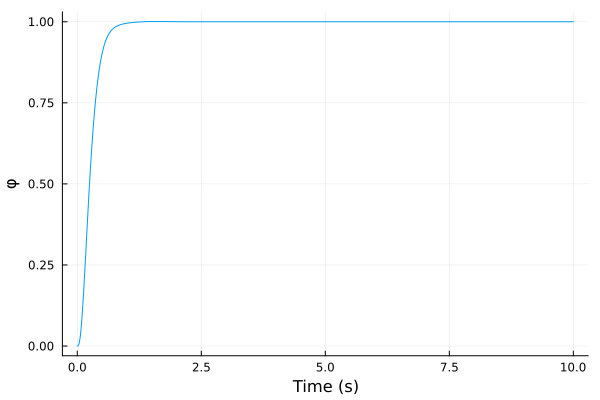

In [15]:
#bank angle reference to bank angle step response
step(P_φβ[:φ, :φ_ref], 10) |> plot

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.058
Peak time:         0.967 s
Overshoot:          5.75 %
Undershoot:         0.00 %
Settling time:     1.358 s
Rise time:         0.469 s


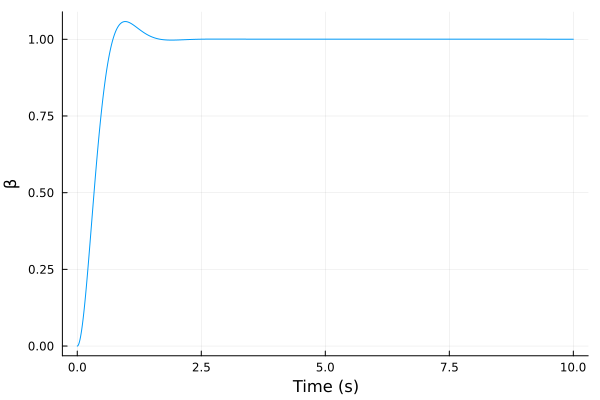

In [16]:
#sideslip angle reference to sideslip angle step response
step(P_φβ[:β, :β_ref], 10) |> stepinfo |> display
step(P_φβ[:β, :β_ref], 10) |> plot

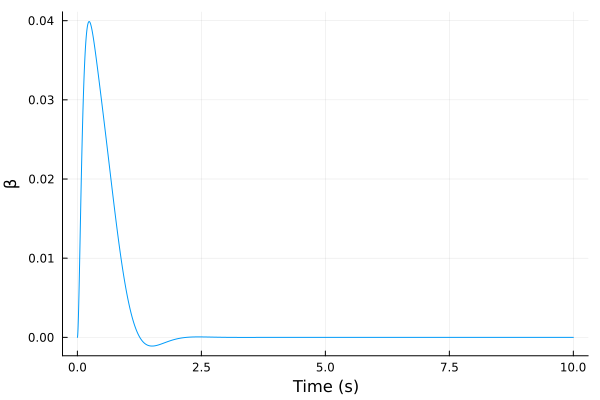

In [17]:
step(P_φβ[:β, :φ_ref], 10) |> plot

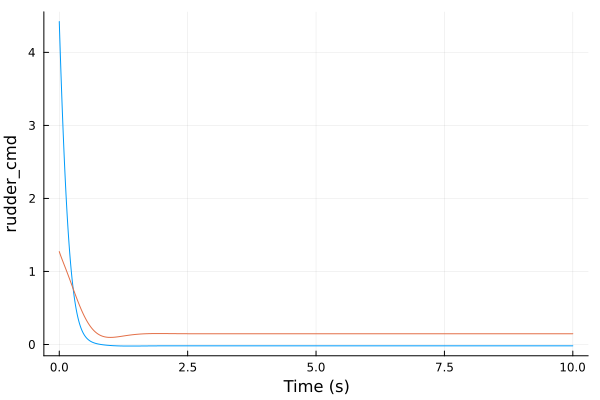

In [18]:
step(P_φβ[:aileron_cmd, :φ_ref], 10) |> plot
step(P_φβ[:rudder_cmd, :φ_ref], 10) |> plot!

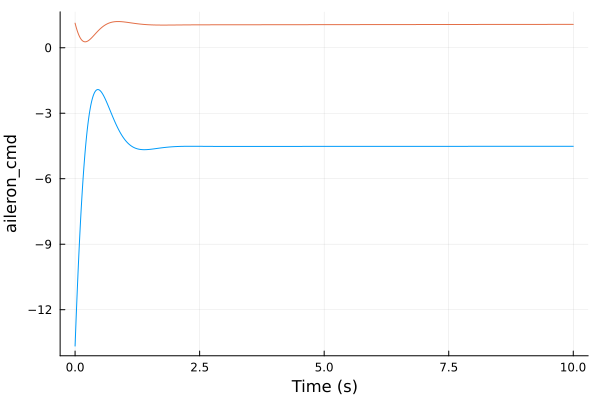

In [19]:
step(P_φβ[:rudder_cmd, :β_ref], 10) |> plot
step(P_φβ[:aileron_cmd, :β_ref], 10) |> plot!

### 2.1.1. Roll Rate Control Augmentation

We now design a roll rate CAS on top of the plant with $\phi$ and $\beta$ tracking. This will be a
SISO loop connected to the $\phi_{sp}$ input. That is, we will provide roll rate tracking via the
bank angle set point. Clearly, one integrator will be needed in the feedforward path to yield a
type-0 open-loop system. And another one to achieve type 1 (zero steady-state roll rate error).

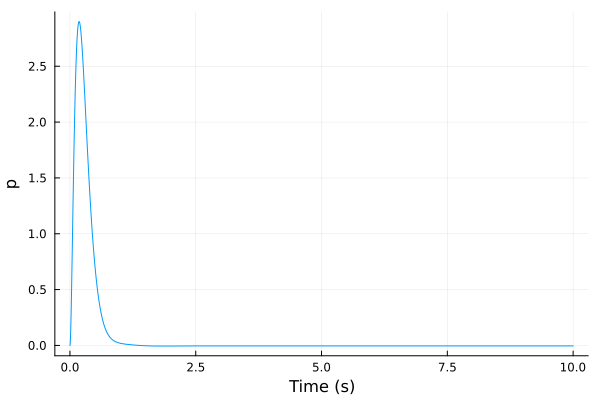

In [20]:
P_φ2p = P_φβ[:p, :φ_ref];
step(P_φ2p, 10) |> plot

In [21]:
data = zpkdata(P_φ2p)
data[1] |> display
data[2] |> display
data[3] |> display

1×1 Matrix{Vector{ComplexF64}}:
 [-19.84725483952258 + 0.0im, -2.981196086373812 + 3.41991337318953im, -2.981196086373812 - 3.41991337318953im, -0.08341907817488278 + 0.0im, 0.00434424862615678 + 0.0im, -2.3560433278597335e-6 + 0.0im]

1×1 Matrix{Vector{ComplexF64}}:
 [-20.33094295888796 + 0.0im, -19.850005684082216 + 0.0im, -7.522576236042025 + 3.2491301860071453im, -7.522576236042025 - 3.2491301860071453im, -3.088483619970465 + 3.365783988772011im, -3.088483619970465 - 3.365783988772011im, -0.08341903105480492 + 0.0im, -1.8673896099044577e-7 + 0.0im]

1×1 Matrix{Float64}:
 1383.9669283979206

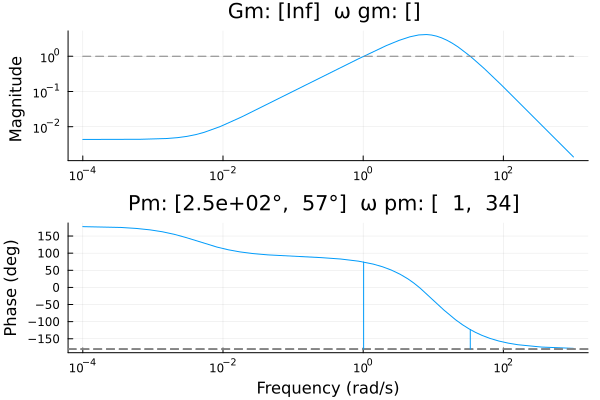

In [22]:
marginplot(P_φ2p, adjust_phase_start = false)


┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

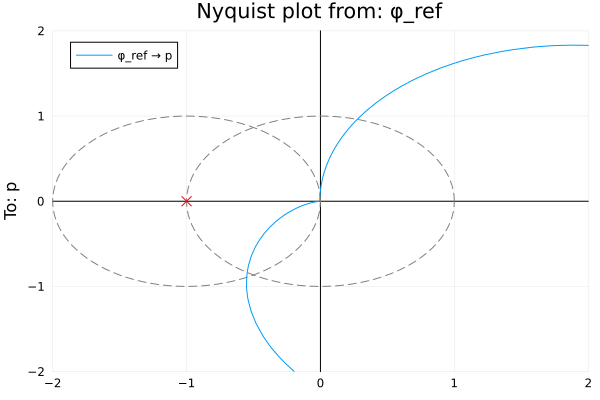

In [23]:
nyquistplot(P_φ2p; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

In [24]:
#the resulting design is not going to be stable (sustained roll rate is
#inherently divergent), so we should no use Ms as a performance metric. it's
#only the short term step response that we optimize for.
p2φ_int = tf(1, [1, 0]) |> ss
P_p2φ_opt = series(p2φ_int, ss(P_φ2p))

t_sim_p2φ = 10
lower_bounds = PIDData(; k_p = 0.1, k_i = 0.0, k_d = 0.0, τ_f = 0.01)
upper_bounds = PIDData(; k_p = 10.0, k_i = 35.0, k_d = 1.5, τ_f = 0.01)
settings = Settings(; t_sim = t_sim_p2φ, lower_bounds, upper_bounds)
weights = Metrics(; Ms = 0, ∫e = 2, ef = 2, ∫u = 1, up = 0.00)
data_0 = PIDData(; k_p = 1.5, k_i = 3, k_d = 0.1, τ_f = 0.01)

p2φ_results = optimize_PID(P_p2φ_opt; data_0, settings, weights, global_search)

(; k_p, k_i, k_d, T_i, T_d) = p2φ_results.data
@show k_p, k_i, k_d, T_i, T_d
@show p2φ_results.metrics
@show p2φ_results.exit_flag

(k_p, k_i, k_d, T_i, T_d) = (1.6028886720490059, 7.244485623303425, 0.09774731870778305, 0.2212563811146197, 0.060981976111185957)
p2φ_results.metrics = [1000.0, 0.01472447068254214, 0.0006250775711811318, 0.03790840186843867, 10.377620542827312]
p2φ_results.exit_flag = :ROUNDOFF_LIMITED


:ROUNDOFF_LIMITED

In [25]:
p2φ_PID = build_PID(p2φ_results.data)
C_p2φ = named_ss(series(p2φ_int, p2φ_PID), :C_p2φ; u = :p_err, y = :φ_ref)

C_p2φ: NamedStateSpace{Continuous, Float64}
A = 
 -100.0  0.0  32.0
    4.0  0.0   0.0
    0.0  0.0   0.0
B = 
 0.0
 0.0
 1.0
C = 
 -30.319646920453973  5.659754393205801  11.377620542827312
D = 
 0.0

Continuous-time state-space model
With state  names: C_p2φx1 C_p2φx2 C_p2φx3
     input  names: p_err
     output names: φ_ref


StepInfo:
Initial value:     0.000
Final value:       0.999
Step size:         0.999
Peak:              1.004
Peak time:         0.426 s
Overshoot:          0.49 %
Undershoot:         0.00 %
Settling time:     0.317 s
Rise time:         0.197 s


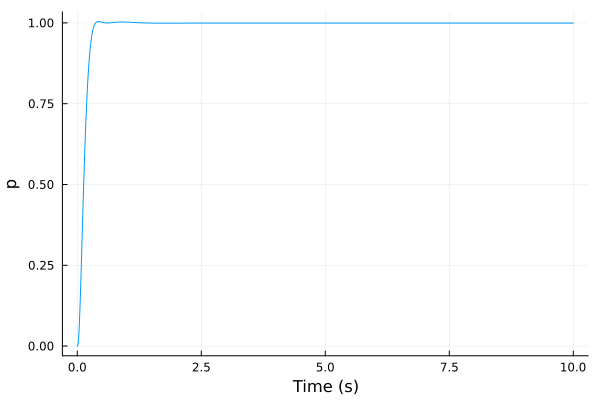

In [26]:
#closed loop transfer function
T_p2φ = output_comp_sensitivity(P_φ2p, C_p2φ)
T_p2φ_step_SISO = step(T_p2φ, t_sim_p2φ)
stepinfo(T_p2φ_step_SISO) |> display
T_p2φ_step_SISO |> plot

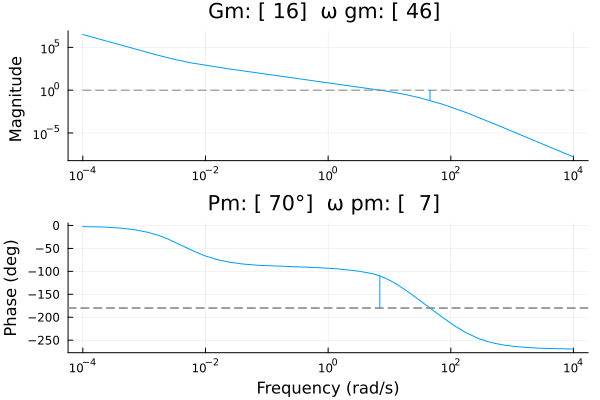

In [27]:
#loop transfer function
L_p2φ = series(C_p2φ, P_φ2p)
marginplot(L_p2φ)

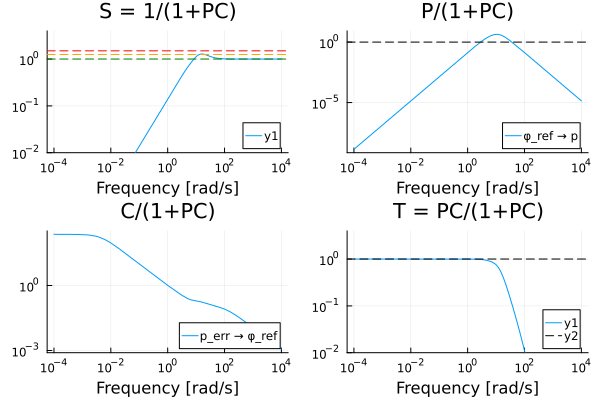

In [28]:
gangoffourplot(P_φ2p, C_p2φ)

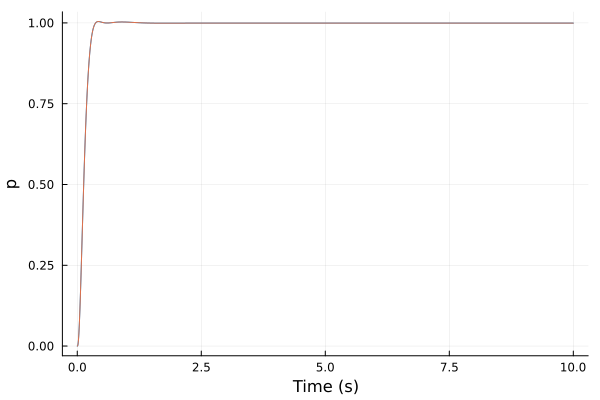

In [29]:
p2φ_sum = sumblock("p_err = p_ref - p")
P_pβ = connect([P_φβ, p2φ_sum, C_p2φ], [:p_err=>:p_err, :p=>:p, :φ_ref=>:φ_ref], w1 = [:p_ref, :β_ref], z1 = P_φβ.y)

#cross-check SISO and MIMO responses
step(P_pβ[:p, :p_ref], t_sim_p2φ) |> plot
T_p2φ_step_SISO |> plot!

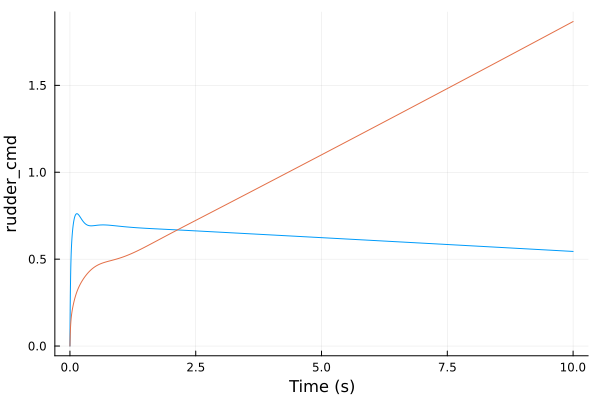

In [30]:
#roll rate to aileron and rudder actuator commands
step(P_pβ[:aileron_cmd, :p_ref], t_sim_p2φ) |> plot
step(P_pβ[:rudder_cmd, :p_ref], t_sim_p2φ) |> plot!

To avoid transients on mode changes, we want the initial output of the roll rate loop to match the current value of the bank angle reference at the roll-yaw SAS input, $\phi_{sp}$.

Whenever roll rate mode is enabled after a mode change, we first reset both the integrator and the PID. Then we set PID integrator's state to the appropriate value to achieve the required $\phi_{sp}$. We have:
$$ y_{int} = 0 $$
$$ y_{pid} = k_p y_{int} + k_i x_{i0} = k_i x_{i0} = \phi_{sp} $$

Therefore:
$$x_{i0} = \phi_{sp}/k_i$$

### 2.2.2. Course Angle Tracker

We start from the plant with embedded bank angle and sideslip control.

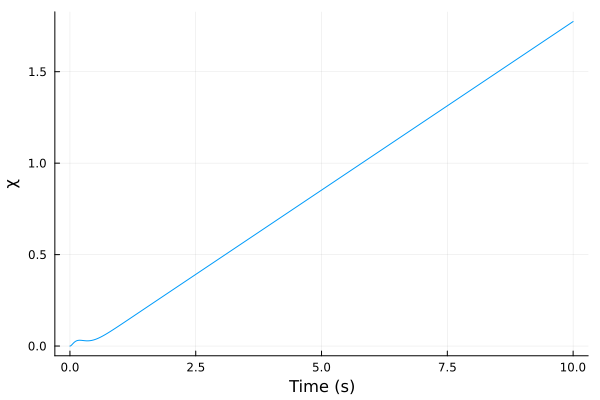

In [31]:
P_φ2χ = P_φβ[:χ, :φ_ref];
step(P_φ2χ, 10) |> plot

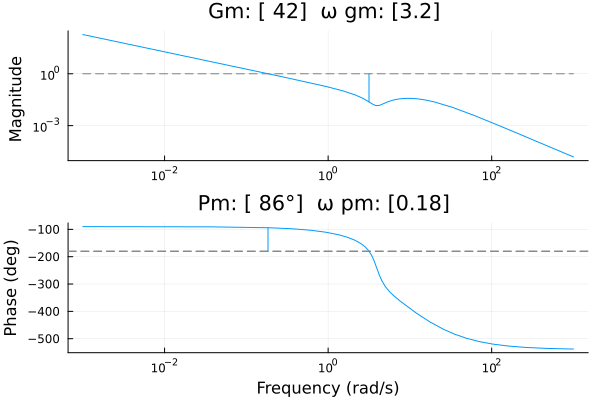

In [32]:
marginplot(P_φ2χ)

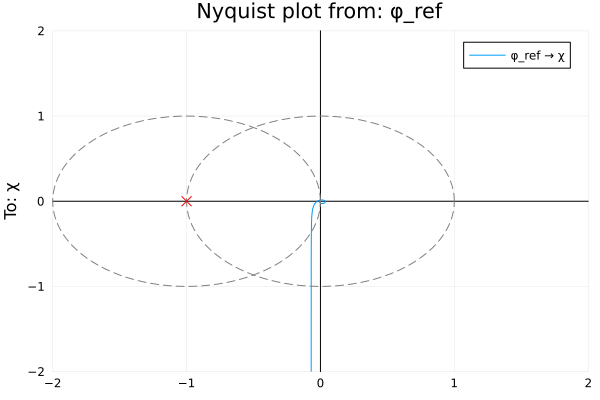

In [33]:
nyquistplot(P_φ2χ; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

We can see that without compensation the loop transfer function is already type-1, that is, gain goes to infinity for zero frequency. This ensures zero steady-state error, but not in the presence of external disturbances (such as crosswind). For zero steady-state disturbances rejection we need integral compensation. The result is a type 2 open loop system.

In [34]:
t_sim_χ2φ = 30
lower_bounds = PIDData(; k_p = 0.1, k_i = 0.4, k_d = 0.0, τ_f = 0.01)
upper_bounds = PIDData(; k_p = 10.0, k_i = 0.4, k_d = 1.5, τ_f = 0.01)
settings = Settings(; t_sim = t_sim_χ2φ, lower_bounds, upper_bounds)
weights = Metrics(; Ms = 3, ∫e = 10, ef = 1, ∫u = 0.00, up = 0.01)
data_0 = PIDData(; k_p = 3., k_i = 0.4, k_d = 0.0, τ_f = 0.01)


χ2φ_results = optimize_PID(P_φ2χ; data_0, settings, weights, global_search)
χ2φ_PID = build_PID(χ2φ_results.data)
C_χ2φ = named_ss(χ2φ_PID, :C_χ2φ; u = :χ_err, y = :φ_ref);

(; k_p, k_i, k_d, T_i, T_d) = χ2φ_results.data
@show k_p, k_i, k_d, T_i, T_d
@show χ2φ_results.metrics
@show χ2φ_results.exit_flag

(k_p, k_i, k_d, T_i, T_d) = (3.9597900854586445, 0.4, 0.0, 9.89947521364661, 0.0)
χ2φ_results.metrics = [1.231870483158924, 0.07914890020202012, 0.00621098757890004, 1.0332406751682823, 2.9601266269244175]
χ2φ_results.exit_flag = :ROUNDOFF_LIMITED


:ROUNDOFF_LIMITED

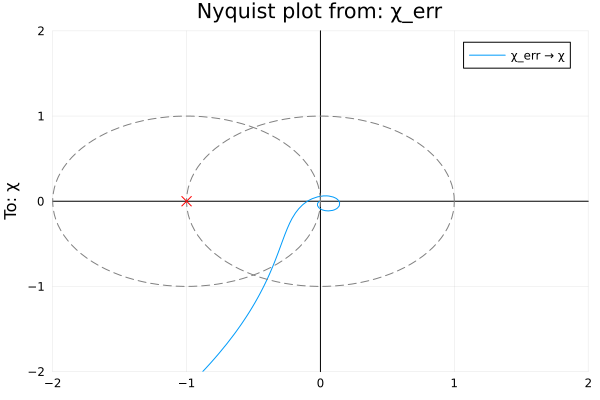

In [35]:
L_χ2φ = series(C_χ2φ, P_φ2χ)
nyquistplot(L_χ2φ, unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

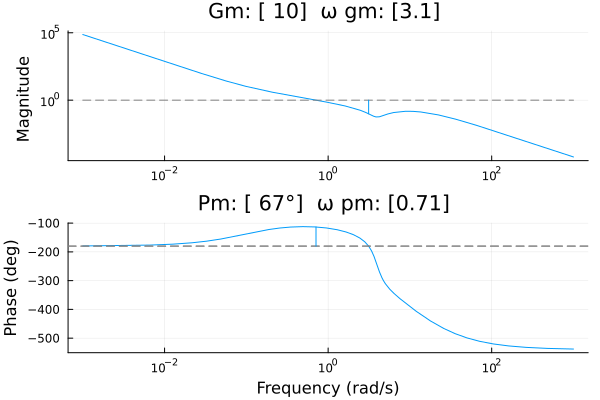

In [36]:
marginplot(L_χ2φ)

Here we are particularly interested in the load disturbance to output transfer function P/(1+C). In order for the controller to be able to counter the effects of crosswind, this function needs to show low frequency roll-off. And indeed, forcing a nonzero integral term in the PID achieves this goal.

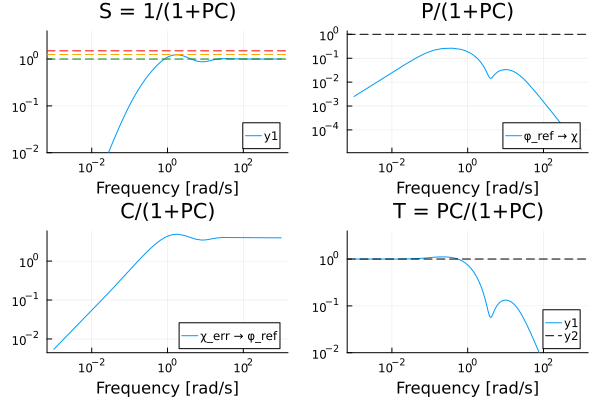

In [37]:
gangoffourplot(P_φ2χ, C_χ2φ)

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.110
Peak time:         5.010 s
Overshoot:         10.96 %
Undershoot:         0.00 %
Settling time:    20.167 s
Rise time:         2.045 s


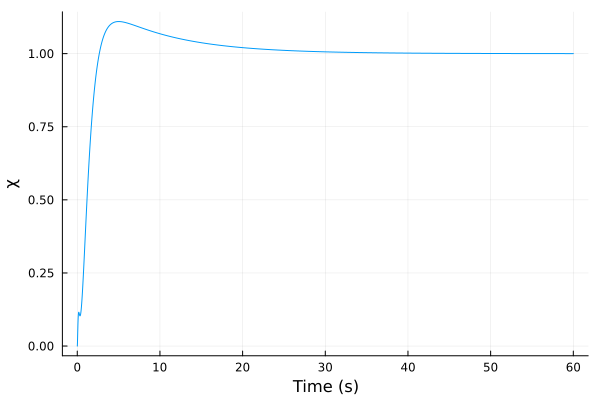

In [38]:
T_χ2φ = output_comp_sensitivity(P_φ2χ, C_χ2φ) #input to output response
T_χ2φ_step_SISO = step(T_χ2φ, 2t_sim_χ2φ)
stepinfo(T_χ2φ_step_SISO) |> display
T_χ2φ_step_SISO |> plot

The drawback of integral action in this case is the relatively large overshoot. However, here we
need to consider the input to control signal response, because unlike in the linear model, our
actual bank angle demand will be limited. In this case, saturation should work in our favor. For
large initial step responses, the anti-windup will halt integration before the integrator's state
reaches the values predicted by the linear model. Therefore, for large changes in reference input,
the actual overshoot should be smaller than predicted here.

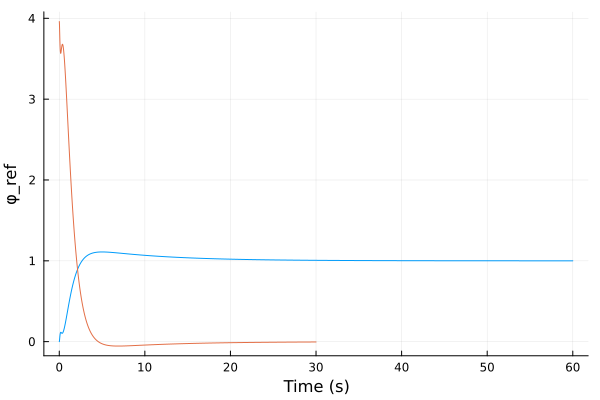

In [39]:
#course angle reference (input) to bank angle (output) response
CS_χ2φ = G_CS(P_φ2χ, C_χ2φ)
CS_χ2φ_step = step(CS_χ2φ, t_sim_χ2φ)
CS_χ2φ_step |> plot!

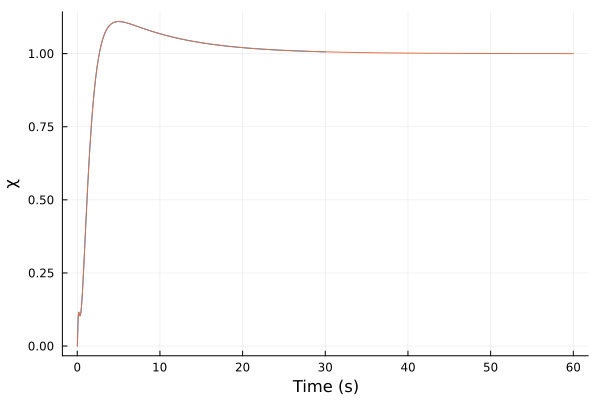

In [40]:
χ2φ_sum = sumblock("χ_err = χ_ref - χ")
P_χβ = connect([P_φβ, χ2φ_sum, C_χ2φ], [:χ_err=>:χ_err, :χ=>:χ, :φ_ref=>:φ_ref], w1 = [:χ_ref, :β_ref], z1 = P_φβ.y)

#cross-check SISO and MIMO responses
step(P_χβ[:χ, :χ_ref], t_sim_χ2φ) |> plot
T_χ2φ_step_SISO |> plot!

To avoid transients on mode changes, we want the initial output of the course angle loop to match the current value of the bank angle reference at the roll-yaw SAS input, $\phi_{sp}$.

Whenever $\chi2\phi$ is enabled after a mode change, we reset the PID. Then we set the PID integrator's state to the appropriate value to achieve the required $\phi$. We have:
$$ y_{pid} = k_p (\chi_{sp} - \chi) + k_i x_{i0} = k_i x_{i0} $$
$$ \phi_{sp} = y_{pid}$$

Therefore:
$$x_{i0} = y_{pid} / k_i = \phi_{sp}/k_i = \phi/k_i$$